In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 로드

In [90]:
BASE_PATH = os.path.join("..", "data")

train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

interest_data = pd.read_csv(os.path.join(BASE_PATH, 'interestRate.csv'))

In [91]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   area_m2              float64
 2   contract_year_month  int64  
 3   contract_day         int64  
 4   contract_type        int64  
 5   floor                int64  
 6   built_year           int64  
 7   latitude             float64
 8   longitude            float64
 9   age                  int64  
 10  deposit              float64
dtypes: float64(4), int64(7)
memory usage: 151.2 MB


In [92]:
train_data["deposit_per_area"] = train_data["deposit"] / train_data["area_m2"]

## 중복 데이터 처리

In [93]:
train_data = train_data.drop(columns=["index"]).drop_duplicates(keep="first")

In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1717611 entries, 0 to 1801227
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   area_m2              float64
 1   contract_year_month  int64  
 2   contract_day         int64  
 3   contract_type        int64  
 4   floor                int64  
 5   built_year           int64  
 6   latitude             float64
 7   longitude            float64
 8   age                  int64  
 9   deposit              float64
 10  deposit_per_area     float64
dtypes: float64(5), int64(6)
memory usage: 157.3 MB


## 월별 거래량 산출하여 train_data에 피처 추가

In [95]:
monthly_transaction = train_data.groupby('contract_year_month').size().reset_index(name="monthly_transaction")

train_data = pd.merge(train_data, monthly_transaction, on="contract_year_month", how="left")

In [96]:
new_data = train_data.groupby("contract_year_month").agg({
    "deposit": "mean",
    "deposit_per_area": "mean",
    "area_m2": "mean",
    "age": "mean",
    "monthly_transaction": "mean"
}).reset_index()

In [97]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   contract_year_month  57 non-null     int64  
 1   deposit              57 non-null     float64
 2   deposit_per_area     57 non-null     float64
 3   area_m2              57 non-null     float64
 4   age                  57 non-null     float64
 5   monthly_transaction  57 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 2.8 KB


In [108]:
new_data.head()

,contract_year_month,deposit,deposit_per_area,area_m2,age,monthly_transaction
0,201904,30459.486563,407.777229,75.170976,15.867026,21508.0
1,201905,31149.264351,414.812430,75.488048,16.032239,22054.0
2,201906,31188.259433,421.400454,74.995201,16.047300,22368.0
3,201907,31786.283137,425.873734,75.291742,16.125036,24497.0
4,201908,31822.314575,425.171789,75.456185,15.821651,24452.0


In [107]:
interest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_month     66 non-null     int64  
 1   interest_rate  66 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


# 중복 제거 train 데이터프레임과 interest 데이터프레임 병합

In [109]:
new_df = pd.merge(new_data, interest_data, 
                  left_on="contract_year_month", right_on="year_month", how="left").drop(columns="year_month")

new_df["contract_year_month"] = pd.to_datetime(new_df["contract_year_month"], format="%Y%m")

In [110]:
new_df.head(2)

,contract_year_month,deposit,deposit_per_area,area_m2,age,monthly_transaction,interest_rate
0,2019-04-01,30459.486563,407.777229,75.170976,15.867026,21508.0,1.85
1,2019-05-01,31149.264351,414.812430,75.488048,16.032239,22054.0,1.85


## 새로 만들어진 데이터프레임의 상관관계 지수와 기존 데이터프레임의 상관관계 지수 비교

In [111]:
corr_m_new = new_df.corr()
corr_m_new.sort_index()

,contract_year_month,deposit,deposit_per_area,area_m2,age,monthly_transaction,interest_rate
age,0.677486,0.637770,0.659758,-0.279094,1.000000,0.490520,0.211067
area_m2,-0.164974,-0.100485,-0.256589,1.000000,-0.279094,-0.079494,0.091760
contract_year_month,1.000000,0.691981,0.692663,-0.164974,0.677486,0.725232,0.769114
deposit,0.691981,1.000000,0.986560,-0.100485,0.637770,0.469812,0.207439
deposit_per_area,0.692663,0.986560,1.000000,-0.256589,0.659758,0.477943,0.179251
interest_rate,0.769114,0.207439,0.179251,0.091760,0.211067,0.497830,1.000000
monthly_transaction,0.725232,0.469812,0.477943,-0.079494,0.490520,1.000000,0.497830


In [112]:
train_data.columns

Index(['area_m2', 'contract_year_month', 'contract_day', 'contract_type',
       'floor', 'built_year', 'latitude', 'longitude', 'age', 'deposit',
       'deposit_per_area', 'monthly_transaction'],
      dtype='object')

In [117]:
origin_data = pd.merge(train_data, interest_data,
                       left_on="contract_year_month", right_on="year_month", how="left").drop(columns="year_month")

corr_m_org = origin_data[["area_m2", "contract_year_month", "contract_type", "built_year", "age", "deposit", "deposit_per_area", "monthly_transaction", "interest_rate"]].corr()
corr_m_org.sort_index()

,area_m2,contract_year_month,contract_type,built_year,age,deposit,deposit_per_area,monthly_transaction,interest_rate
age,-0.084285,0.043466,-0.006263,-0.992565,1.000000,-0.137116,-0.173445,0.028531,0.013743
area_m2,1.000000,-0.008665,0.007081,0.083009,-0.084285,0.522559,-0.009149,-0.003655,0.004005
built_year,0.083009,0.078417,-0.072196,1.000000,-0.992565,0.145462,0.184264,0.061892,0.078155
contract_type,0.007081,-0.647300,1.000000,-0.072196,-0.006263,-0.084579,-0.109227,-0.548975,-0.519548
contract_year_month,-0.008665,1.000000,-0.647300,0.078417,0.043466,0.072127,0.093010,0.738465,0.760217
deposit,0.522559,0.072127,-0.084579,0.145462,-0.137116,1.000000,0.783901,0.048701,0.023686
deposit_per_area,-0.009149,0.093010,-0.109227,0.184264,-0.173445,0.783901,1.000000,0.063240,0.024909
interest_rate,0.004005,0.760217,-0.519548,0.078155,0.013743,0.023686,0.024909,0.491009,1.000000
monthly_transaction,-0.003655,0.738465,-0.548975,0.061892,0.028531,0.048701,0.063240,1.000000,0.491009


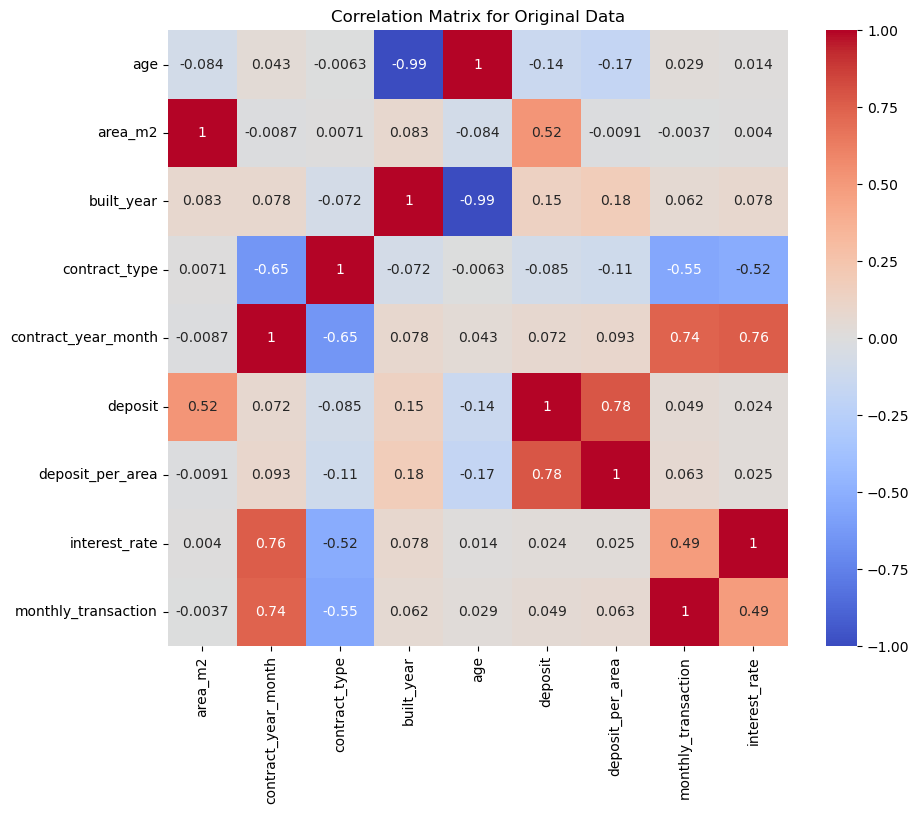

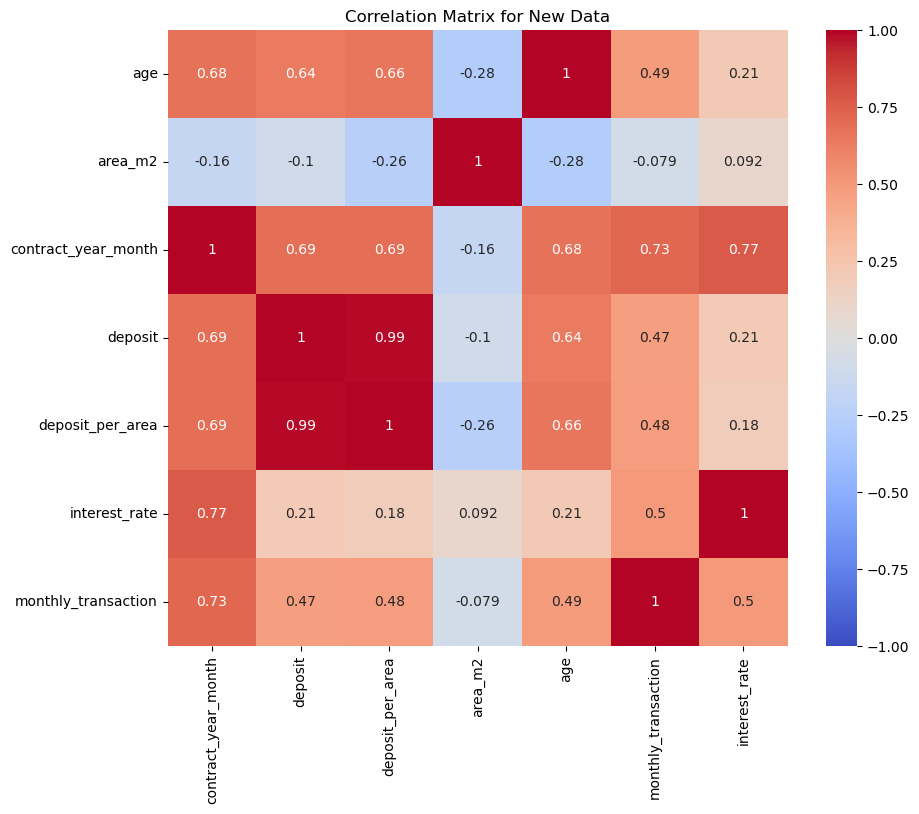

In [120]:
# corr_m_org 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_m_org.sort_index(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Original Data')
plt.show()

# corr_m_new 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_m_new.sort_index(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for New Data')
plt.show()


- interest_rate와 contract_year_month는 0.77의 상관계수 값을 가지며, 이는 시간의 흐름에 따라 금리 상승 추세를 보여줌
- interest_rate와 monthly_transaction은 0.5의 상관계수 값을 가지며, 이는 금리가 상승할 때 거래량이 다소 증가하는 경향이 있을 수 있음을 나타냄.

## mean이 아닌 median과의 비교

## 그래프 확인

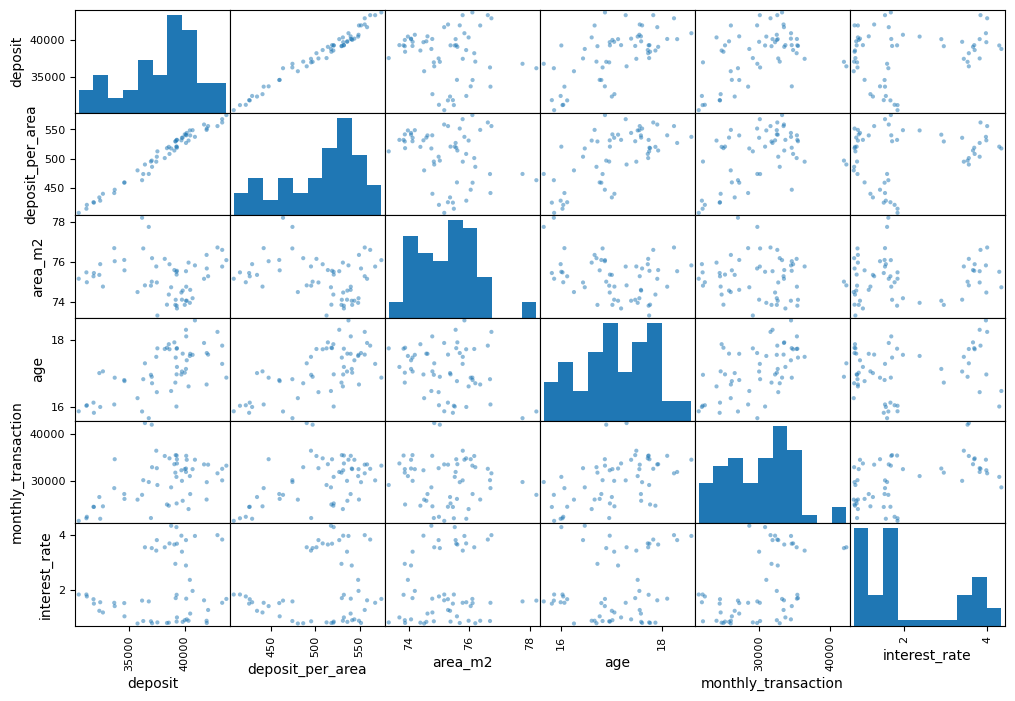

In [125]:
from pandas.plotting import scatter_matrix

scatter_matrix(new_df, figsize=(12, 8))
plt.show()

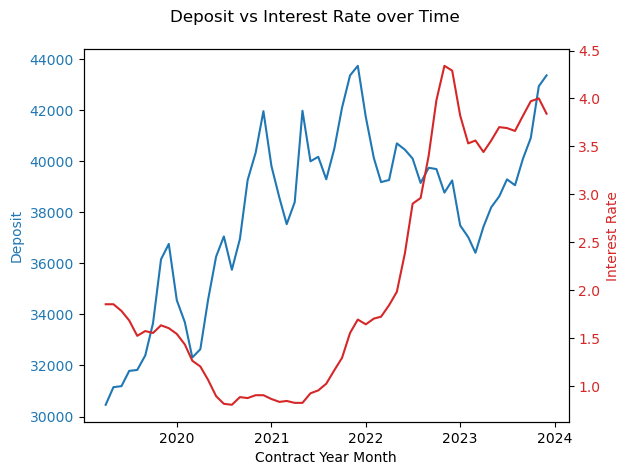

In [140]:
# 연월별 금리와 전세가의 평균 계산
monthly_data = origin_data.groupby('contract_year_month').agg({
    'deposit': 'mean',
    'interest_rate': 'mean'
}).reset_index()

monthly_data["contract_year_month"] = pd.to_datetime(monthly_data["contract_year_month"], format="%Y%m")

# 시계열 그래프
fig, ax1 = plt.subplots()

# 첫 번째 축: 전세가
ax1.plot(monthly_data['contract_year_month'], monthly_data['deposit'], color='tab:blue', label='Deposit')
ax1.set_xlabel('Contract Year Month')
ax1.set_ylabel('Deposit', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 두 번째 축: 금리
ax2 = ax1.twinx()
ax2.plot(monthly_data['contract_year_month'], monthly_data['interest_rate'], color='tab:red', label='Interest Rate')
ax2.set_ylabel('Interest Rate', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 제목 및 범례 설정
fig.suptitle('Deposit vs Interest Rate over Time')
fig.tight_layout()
plt.show()

In [142]:
monthly_data.corr()

,contract_year_month,deposit,interest_rate
contract_year_month,1.000000,0.691981,0.769114
deposit,0.691981,1.000000,0.207439
interest_rate,0.769114,0.207439,1.000000


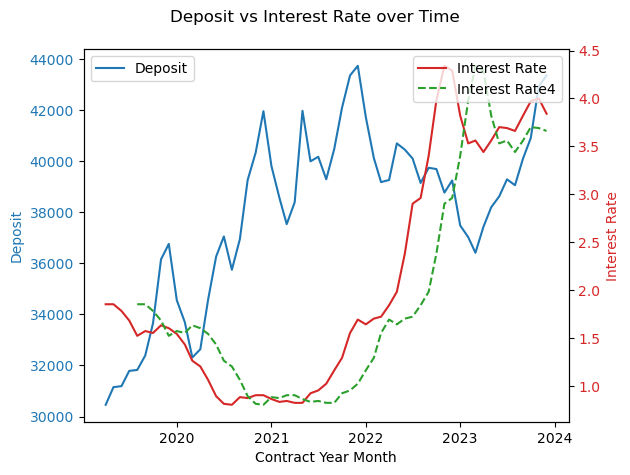

In [165]:
# 연월별 금리와 전세가의 평균 계산
monthly_data = origin_data.groupby('contract_year_month').agg({
    'deposit': 'mean',
    'interest_rate': 'mean'
}).reset_index()

monthly_data["contract_year_month"] = pd.to_datetime(monthly_data["contract_year_month"], format="%Y%m")

# 금리 데이터를 4개월 시차로 이동 (shift4 컬럼 생성)
monthly_data['shift4'] = monthly_data['interest_rate'].shift(4)

# 시계열 그래프
fig, ax1 = plt.subplots()

# 첫 번째 축: 전세가
ax1.plot(monthly_data['contract_year_month'], monthly_data['deposit'], color='tab:blue', label='Deposit')
ax1.set_xlabel('Contract Year Month')
ax1.set_ylabel('Deposit', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 두 번째 축: 금리
ax2 = ax1.twinx()
ax2.plot(monthly_data['contract_year_month'], monthly_data['interest_rate'], color='tab:red', label='Interest Rate')
ax2.plot(monthly_data['contract_year_month'], monthly_data['shift4'], color='tab:green', label='Interest Rate4', linestyle='dashed')
ax2.set_ylabel('Interest Rate', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 범례
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 제목 및 범례 설정
fig.suptitle('Deposit vs Interest Rate over Time')
fig.tight_layout()
plt.show()

In [168]:
monthly_data['shift-1'] = monthly_data['interest_rate'].shift(-1)
monthly_data['shift-2'] = monthly_data['interest_rate'].shift(-2)
monthly_data['shift-3'] = monthly_data['interest_rate'].shift(-3)
monthly_data['shift-5'] = monthly_data['interest_rate'].shift(-5)
monthly_data['shift-6'] = monthly_data['interest_rate'].shift(-6)
monthly_data['shift1'] = monthly_data['interest_rate'].shift(1)
monthly_data['shift2'] = monthly_data['interest_rate'].shift(2)
monthly_data['shift3'] = monthly_data['interest_rate'].shift(3)
monthly_data['shift4'] = monthly_data['interest_rate'].shift(4)
monthly_data['shift5'] = monthly_data['interest_rate'].shift(5)
monthly_data['shift6'] = monthly_data['interest_rate'].shift(6)
monthly_data.corr()

,contract_year_month,deposit,interest_rate,shift4,shift-1,shift-2,shift-3,shift1,shift2,shift3,shift-5,shift-6,shift5,shift6
contract_year_month,1.000000,0.691981,0.769114,0.715221,0.784170,0.799839,0.814490,0.758352,0.745074,0.730381,0.837360,0.848744,0.699875,0.682364
deposit,0.691981,1.000000,0.207439,-0.026378,0.221815,0.234625,0.255216,0.152631,0.086295,0.021490,0.323187,0.363659,-0.045162,-0.055678
interest_rate,0.769114,0.207439,1.000000,0.895280,0.988500,0.963081,0.931184,0.988500,0.963081,0.931184,0.857550,0.817698,0.857550,0.817698
shift4,0.715221,-0.026378,0.895280,1.000000,0.857550,0.817698,0.778995,0.928279,0.959789,0.987041,0.698967,0.656708,0.986413,0.955425
shift-1,0.784170,0.221815,0.988500,0.857550,1.000000,0.988500,0.963177,0.963081,0.931184,0.895280,0.896566,0.858781,0.817698,0.778995
shift-2,0.799839,0.234625,0.963081,0.817698,0.988500,1.000000,0.988558,0.931184,0.895280,0.857550,0.932742,0.897643,0.778995,0.739901
shift-3,0.814490,0.255216,0.931184,0.778995,0.963177,0.988558,1.000000,0.895280,0.857550,0.817698,0.964139,0.933302,0.739901,0.698967
shift1,0.758352,0.152631,0.988500,0.928279,0.963081,0.931184,0.895280,1.000000,0.988339,0.961871,0.817698,0.778995,0.890678,0.851174
shift2,0.745074,0.086295,0.963081,0.959789,0.931184,0.895280,0.857550,0.988339,1.000000,0.987709,0.778995,0.739901,0.924584,0.884641
shift3,0.730381,0.021490,0.931184,0.987041,0.895280,0.857550,0.817698,0.961871,0.987709,1.000000,0.739901,0.698967,0.957763,0.920264


- 직접적인 금리 수치와 실거래가 사이의 상관관계 지수는 0.21 수준으로, 일반적으로 생각하는 금리 인하시 거래가가 높아지는 반비례 관계가 직접적인 수치로 나오지 않음.
- 관련하여 중앙 정부의 시그널로 인해, 시장 참여자들이 선반영하는 것은 아닐까 하여 금리 데이터를 전후 1개월씩 최대 6개월까지 확인하였지만, 뚜렷한 해석이 불가능
<br>
**추가 가정**
- 그렇다면 일반적인 금리가 아니라, 금리 변동에 따른 평균 실거래가, 평균 실거래가의 변동에는 영향이 크지 않을까?

In [171]:
monthly_data["diff_interest"] = monthly_data["interest_rate"].diff()
monthly_data["diff_deposit"] = monthly_data["deposit"].diff()

In [174]:
monthly_data[["interest_rate", "diff_interest", "deposit", "diff_deposit"]].corr()

,interest_rate,diff_interest,deposit,diff_deposit
interest_rate,1.000000,0.207719,0.207439,-0.045405
diff_interest,0.207719,1.000000,0.395599,0.093656
deposit,0.207439,0.395599,1.000000,0.131755
diff_deposit,-0.045405,0.093656,0.131755,1.000000


- 금리의 변동(diff_interest)는 실거래가의 변동 그 자체보다는, 실거래가 자체에 영향력이 큼.
- 금리 자체보다 금리 변동이 전세가에 더 중요한 변수로 작용할 수 있음
- interest_rate보다는 contract_year_month에 따른 금리 변동을 나타내는 피처를 추가하여 모델을 학습시키는 것이 더 나을 것으로 추정